# Installation

`Runtime > Change Runtime Type` and select `GPU`.


In [ ]:
!pip install sidechainnet --quiet

import sidechainnet as scn
import numpy as np
import torch

np.set_printoptions(suppress=True)
np.random.seed(0)
torch.manual_seed(0)


     |████████████████████████████████| 47.6 MB 2.3 MB/s 
     |████████████████████████████████| 11.9 MB 34.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3 MB 39.7 MB/s 


@> ProDy is configured: verbosity='none'


# Visualizing predictions


In [ ]:
def build_visualizable_structures(model, data, mode=None):
  """Build visualizable structures for one batch of model's predictions on data."""
  with torch.no_grad():
    for batch in data:
      if mode == "seqs":
        model_input = batch.int_seqs.to(device)
      elif mode == "pssms":
        model_input = batch.seq_evo_sec.to(device)

      # Make predictions for angles, and construct 3D atomic coordinates
      predicted_angles_sincos = model(model_input)
      # Because the model predicts sin/cos values, we use this function to recover the original angles
      predicted_angles = inverse_trig_transform(predicted_angles_sincos)

      # EXAMPLE
      # Use BatchedStructureBuilder to build an entire batch of structures
      sb_pred = scn.BatchedStructureBuilder(batch.int_seqs, predicted_angles.cpu())
      sb_true = scn.BatchedStructureBuilder(batch.int_seqs, batch.crds.cpu())
      break
  return sb_pred, sb_true

# RGN

## Accessing Data via PyTorch Dataloaders

In [ ]:

d = scn.load(casp_version=12, thinning=30, # "debug", 
             with_pytorch='dataloaders', 
             dynamic_batching=True, 
             batch_size=32)
print("Available Dataloaders =", list(d.keys()))

SidechainNet(12, 30) was not found in ./sidechainnet_data.


Downloaded SidechainNet to ./sidechainnet_data/sidechainnet_casp12_30.pkl.
SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp12_30.pkl.
Available Dataloaders = ['train', 'train-eval', 'test', 'valid-10', 'valid-20', 'valid-30', 'valid-40', 'valid-50', 'valid-70', 'valid-90']


```python
d  =   {"train": {"seq": [seq1, seq2, ...],  # Sequences
                  "ang": [ang1, ang2, ...],  # Angles
                  "crd": [crd1, crd2, ...],  # Coordinates
                  "evo": [evo1, evo2, ...],  # PSSMs and Information Content
                  "sec": [sec1, sec2, ...],  # Secondary structure (DSSP)
                  "res": [res1, res2, ...],  # X-ray crystallographic resolution
                  "ids": [id1, id2,   ...],  # Corresponding ProteinNet IDs
                  },
        "valid-10": {...},
            ...
        "valid-90": {...},
        "test":     {...},
        "settings": {...},
        "description" : "SidechainNet for CASP 12."
        "date": "September 20, 2020"
        }
```

In [ ]:
d['train'].dataset

ProteinDataset(casp_version=12, split='train', thinning=30, n_proteins=25213, created='06:50PM May 19, 2021')

In [ ]:
d['valid-10'].dataset

ProteinDataset(casp_version=12, split='valid-10', n_proteins=32, created='06:50PM May 19, 2021')

## Load a pretrained model "Optional"

In [ ]:
model_file_path = "example_model.pt"

In [ ]:
Loaded_model = ProteinRNN(d_hidden=1024,
                        n_layers=2,
                        d_in=49,
                        d_embedding=32,
                        integer_sequence=False)
Loaded_model.load_state_dict(torch.load(model_file_path))
Loaded_model = Loaded_model.to(device)

In [ ]:
torch.manual_seed(1)
np.random.seed(1)
s_pred, s_true = build_visualizable_structures(Loaded_model, d["train"], mode="pssms")

In [ ]:
s_pred.to_3Dmol(0)

In [ ]:
s_true.to_3Dmol(0)

## Model Training

1.   A sequence only `ProteinRNN` model:
  - takes takes as input amino acid sequences rerpesented as integer tensors ($ℝ^{1}$).
2.   A sequence + `PSSM` `ProteinRNN` model:
  - takes as input a concatenation of the amino acid sequence (one-hot vectors, $ℝ^{20}$), the Position Specific Scoring Matrix ($ℝ^{20}$), and the information content ($ℝ^{1}$).


### Training Sequences -> Angles

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

from sidechainnet.examples import losses, models
from sidechainnet.structure.structure import inverse_trig_transform
from sidechainnet.structure.build_info import NUM_ANGLES


# To train with a GPU, go to Runtime > Change runtime type
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(f"Using {device} for training.")

Using cuda for training.


In [ ]:
class ProteinRNN(torch.nn.Module):
    """A protein sequence-to-angle model that consumes integer-coded sequences."""

    def __init__(self,
                 d_hidden,
                 n_layers=1,
                 d_in=21,
                 d_embedding=32,
                 integer_sequence=True,
                 n_angles=scn.structure.build_info.NUM_ANGLES):
      super(ProteinRNN, self).__init__()
      # Dimensionality of RNN hidden state
      self.d_hidden = d_hidden

      # Number of RNN layers (depth)
      self.n_layers = n_layers

      # Underlying RNN (a Long Short-Term Memory network)
      self.lstm = torch.nn.LSTM(d_embedding,
                                d_hidden,
                                n_layers,
                                bidirectional=False,
                                batch_first=True)

      # Output vector dimensionality (per amino acid)
      self.d_out = n_angles * 2

      # Output projection layer. (from RNN -> target tensor)
      self.hidden2out = torch.nn.Linear(d_hidden, self.d_out)

      # Activation function for the output values (bounds values to [-1, 1])                                  
      self.output_activation = torch.nn.Tanh()

      # We embed our model's input differently depending on the type of input
      self.integer_sequence = integer_sequence
      if self.integer_sequence:
        self.input_embedding = torch.nn.Embedding(d_in, d_embedding, padding_idx=20)
      else:
        self.input_embedding = torch.nn.Linear(d_in, d_embedding)
    
    def init_hidden(self, batch_size):
      """Initialize the hidden state vectors at the start of an iteration."""
      h = torch.zeros(self.n_layers, batch_size, self.d_hidden).to(device)
      c = torch.zeros(self.n_layers, batch_size, self.d_hidden).to(device)
      return h, c
  
    def get_lengths(self, sequence):
      """Compute the lengths of each sequence in the batch."""
      if self.integer_sequence:
        lengths = sequence.shape[-1] - (sequence == 20).sum(axis=1)
      else:
        lengths = sequence.shape[1] - (sequence == 0).all(axis=-1).sum(axis=1)
      return lengths.cpu()
      
    def forward(self, sequence):
      """Run one forward step of the model."""
      # First, we initialize the hidden state vectors and compute sequence lengths
      h, c = self.init_hidden(sequence.shape[0])
      lengths = self.get_lengths(sequence)

      # Next, we embed our input tensors for input to the RNN
      sequence = self.input_embedding(sequence)

      # Then we pass in our data into the RNN via PyTorch's pack_padded_sequences
      sequence = torch.nn.utils.rnn.pack_padded_sequence(sequence,
                                                         lengths,
                                                         batch_first=True,
                                                         enforce_sorted=False)
      output, (h, c) = self.lstm(sequence, (h, c))
      output, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(output,
                                                                      batch_first=True)
      
      # At this point, output has the same dimentionality as the RNN's hidden
      # state: i.e. (batch, length, d_hidden). 
      
      # We use a linear transformation to transform our output tensor into the
      # correct dimensionality (batch, length, 24)
      output = self.hidden2out(output)

      # Next, we need to bound the output values between [-1, 1]
      output = self.output_activation(output)

      # Finally, reshape the output to be (batch, length, angle, (sin/cos val))
      output = output.view(output.shape[0], output.shape[1], 12, 2)

      return output


#### Model

In [ ]:
# Create the model and move it to the GPU
seqonly_model = ProteinRNN(d_hidden=512,
                           d_in=21,
                           n_layers=2)
seqonly_model = seqonly_model.to(device)
seqonly_model

ProteinRNN(
  (lstm): LSTM(32, 512, num_layers=2, batch_first=True)
  (hidden2out): Linear(in_features=512, out_features=24, bias=True)
  (output_activation): Tanh()
  (input_embedding): Embedding(21, 32, padding_idx=20)
)

In [ ]:
# Prepare housekeeping functions to track performance

def evaluate(model, datasplit):
  """Evaluate a model (sequence->sin/cos represented angles [-1,1]) on MSE."""
  total = 0.0
  n = 0
  with torch.no_grad():
    for batch in datasplit:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seqs = batch.int_seqs.to(device)
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize
      pred_angles_sincos = model(seqs)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      total += loss
      n += 1
  return torch.sqrt(total/n)

optimizer = torch.optim.Adam(seqonly_model.parameters())
batch_losses = []
epoch_training_losses = []
epoch_validation10_losses = []
epoch_validation90_losses = []
mse_loss = torch.nn.MSELoss()

##### mount drive, read last model, results, etc... to continue.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Masters/BI/
import pickle

Mounted at /content/drive
/content/drive/MyDrive/Masters/BI


In [ ]:
with open("batch_losses", "rb") as fp:   # Unpickling
   batch_losses = pickle.load(fp)
with open("epoch_training_losses", "rb") as fp:   # Unpickling
   epoch_training_losses = pickle.load(fp)
with open("epoch_validation10_losses", "rb") as fp:   # Unpickling
   epoch_validation10_losses = pickle.load(fp)
with open("epoch_validation90_losses", "rb") as fp:   # Unpickling
   epoch_validation90_losses = pickle.load(fp)
seqonly_model.load_state_dict(torch.load("model"))


<All keys matched successfully>

#### Training

In [ ]:
for epoch in range(5):
  print(f"Epoch {epoch}")
  progress_bar = tqdm(total=len(d['train']), smoothing=0)
  for batch in d['train']:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seqs = batch.int_seqs.to(device).long()
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize

      pred_angles_sincos = seqonly_model(seqs)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      loss.backward()
      torch.nn.utils.clip_grad_norm_(seqonly_model.parameters(), 2)
      optimizer.step()

      # Housekeeping
      batch_losses.append(float(loss))
      progress_bar.update(1)
      progress_bar.set_description(f"\rRMSE Loss = {np.sqrt(float(loss)):.4f}")
  
  # Evaluate the model's performance on train-eval, downsampled for efficiency
  epoch_training_losses.append(evaluate(seqonly_model, d['train-eval']))
  # Evaluate the model's performance on various validation sets
  epoch_validation10_losses.append(evaluate(seqonly_model, d['valid-10']))
  epoch_validation90_losses.append(evaluate(seqonly_model, d['valid-90']))
  print(f"     Train-eval loss = {epoch_training_losses[-1]:.4f}")
  print(f"     Valid-10   loss = {epoch_validation10_losses[-1]:.4f}")
  print(f"     Valid-90   loss = {epoch_validation90_losses[-1]:.4f}")
  if((epoch+1)%5==0):
    with open("batch_losses", "wb") as fp:   # Unpickling
      pickle.dump(batch_losses, fp)
    with open("epoch_training_losses", "wb") as fp:   # Unpickling
      pickle.dump(epoch_training_losses, fp)
    with open("epoch_validation10_losses", "wb") as fp:   # Unpickling
      pickle.dump(epoch_validation10_losses, fp)
    with open("epoch_validation90_losses", "wb") as fp:   # Unpickling
      pickle.dump(epoch_validation90_losses, fp)
    torch.save(seqonly_model.state_dict(), "model")

# Finally, evaluate the model on the test set 
print(f"Test loss = {evaluate(seqonly_model, d['test']):.4f}")

Epoch 0


  0%|          | 0/776 [00:00<?, ?it/s]

     Train-eval loss = 0.4307
     Valid-10   loss = 0.4298
     Valid-90   loss = 0.4261
Epoch 1


  0%|          | 0/776 [00:00<?, ?it/s]

     Train-eval loss = 0.4309
     Valid-10   loss = 0.4313
     Valid-90   loss = 0.4278
Epoch 2


  0%|          | 0/776 [00:00<?, ?it/s]

     Train-eval loss = 0.4281
     Valid-10   loss = 0.4275
     Valid-90   loss = 0.4234
Epoch 3


  0%|          | 0/776 [00:00<?, ?it/s]

     Train-eval loss = 0.4300
     Valid-10   loss = 0.4301
     Valid-90   loss = 0.4241
Epoch 4


  0%|          | 0/776 [00:00<?, ?it/s]

     Train-eval loss = 0.4308
     Valid-10   loss = 0.4309
     Valid-90   loss = 0.4248
Test loss = 0.4236


#### Result

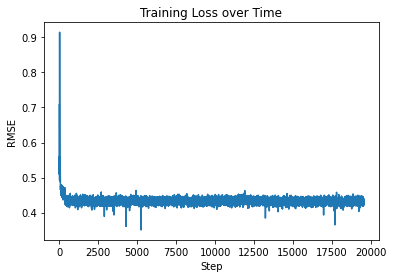

In [ ]:
# Plot the loss of each batch over time
plt.plot(np.sqrt(np.asarray(batch_losses)), label='batch loss')
plt.ylabel("RMSE")
plt.xlabel("Step")
plt.title("Training Loss over Time")
plt.show()

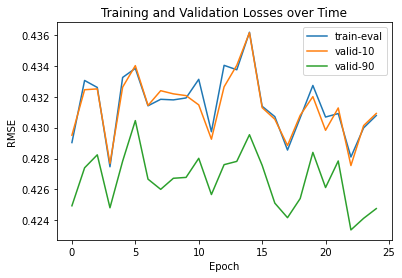

In [ ]:
# While the above plot demonstrates each batch's loss during training,
# the plot below shows the performance of the model on several data splits
# at the *end* of each epoch.
plt.plot(epoch_training_losses, label='train-eval')
plt.plot(epoch_validation10_losses, label='valid-10')
plt.plot(epoch_validation90_losses, label='valid-90')
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.title("Training and Validation Losses over Time")
plt.legend()
plt.show()

In [ ]:
s_pred, s_true = build_visualizable_structures(seqonly_model, d["train"], mode="seqs")

In [ ]:
s_pred.to_3Dmol(0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
s_true.to_3Dmol(0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Training (Sequences, PSSMs, Secondary Structures, and Information Content) -> Angles


#### Model

In [ ]:
pssm_model = ProteinRNN(d_hidden=1024,
                        n_layers=2,
                        d_in=49,
                        d_embedding=32,
                        integer_sequence=False)

In [ ]:
pssm_model.to(device)

def evaluate_pssm(model, datasplit):
  """Evaluate a model with (input:PSSM, output:sin/cos represented angles [-1,1])."""
  total = 0.0
  n = 0
  with torch.no_grad():
    for batch in datasplit:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seq_evo_sec = batch.seq_evo_sec.to(device)
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize
      pred_angles_sincos = model(seq_evo_sec)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      total += loss
      n += 1
  return torch.sqrt(total/n)

optimizer = torch.optim.Adam(pssm_model.parameters())
batch_losses = []
epoch_training_losses = []
epoch_validation10_losses = []
epoch_validation90_losses = []
mse_loss = torch.nn.MSELoss()

#### Train

In [ ]:
for epoch in range(10):
  print(f"Epoch {epoch}")
  progress_bar = tqdm(total=len(d['train']), smoothing=0)
  for batch in d['train']:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seq_evo_sec = batch.seq_evo_sec.to(device)
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize
      pred_angles_sincos = pssm_model(seq_evo_sec)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      loss.backward()
      torch.nn.utils.clip_grad_norm_(pssm_model.parameters(), 1)
      optimizer.step()

      # Housekeeping
      batch_losses.append(float(loss))
      progress_bar.update(1)
      progress_bar.set_description(f"\rRMSE Loss = {np.sqrt(float(loss)):.4f}")
  
  # Evaluate the model's performance on train-eval, downsampled for efficiency
  epoch_training_losses.append(evaluate_pssm(pssm_model, d['train-eval']))
  # Evaluate the model's performance on various validation sets
  epoch_validation10_losses.append(evaluate_pssm(pssm_model, d['valid-10']))
  epoch_validation90_losses.append(evaluate_pssm(pssm_model, d['valid-90']))
  print(f"\tTrain-eval loss = {epoch_training_losses[-1]:.4f}")
  print(f"\tValid-10   loss = {epoch_validation10_losses[-1]:.4f}")
  print(f"\tValid-90   loss = {epoch_validation90_losses[-1]:.4f}")

# Finally, evaluate the model on the test set
print(f"Test loss = {evaluate_pssm(pssm_model, d['test']):.4f}")

Epoch 0


  0%|          | 0/935 [00:00<?, ?it/s]

	Train-eval loss = 0.4162
	Valid-10   loss = 0.4535
	Valid-90   loss = 0.4405
Epoch 1


  0%|          | 0/935 [00:00<?, ?it/s]

	Train-eval loss = 0.4073
	Valid-10   loss = 0.4376
	Valid-90   loss = 0.4313
Epoch 2


  0%|          | 0/935 [00:00<?, ?it/s]

	Train-eval loss = 0.3989
	Valid-10   loss = 0.4291
	Valid-90   loss = 0.4280
Epoch 3


  0%|          | 0/935 [00:00<?, ?it/s]

	Train-eval loss = 0.4038
	Valid-10   loss = 0.4341
	Valid-90   loss = 0.4331
Epoch 4


  0%|          | 0/935 [00:00<?, ?it/s]

	Train-eval loss = 0.3882
	Valid-10   loss = 0.4314
	Valid-90   loss = 0.4203
Epoch 5


  0%|          | 0/935 [00:00<?, ?it/s]

	Train-eval loss = 0.3880
	Valid-10   loss = 0.4245
	Valid-90   loss = 0.4158
Epoch 6


  0%|          | 0/935 [00:00<?, ?it/s]

	Train-eval loss = 0.3894
	Valid-10   loss = 0.4364
	Valid-90   loss = 0.4222
Epoch 7


  0%|          | 0/935 [00:00<?, ?it/s]

	Train-eval loss = 0.3893
	Valid-10   loss = 0.4249
	Valid-90   loss = 0.4178
Epoch 8


  0%|          | 0/935 [00:00<?, ?it/s]

	Train-eval loss = 0.3843
	Valid-10   loss = 0.4261
	Valid-90   loss = 0.4103
Epoch 9


  0%|          | 0/935 [00:00<?, ?it/s]

	Train-eval loss = 0.3872
	Valid-10   loss = 0.4276
	Valid-90   loss = 0.4137
Test loss = 0.4185


#### Result

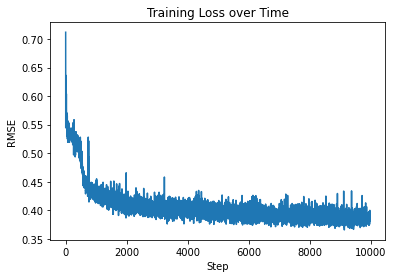

In [ ]:
plt.plot(np.sqrt(np.asarray(batch_losses)))
plt.ylabel("RMSE")
plt.xlabel("Step")
plt.title("Training Loss over Time")
plt.show()

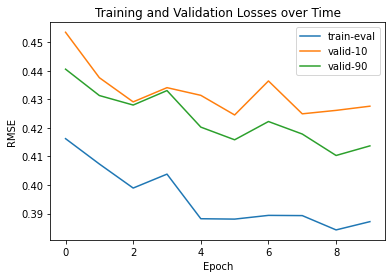

In [ ]:
# While the above plot demonstrates each batch's loss during training,
# the plot below shows the performance of the model on several data splits
# at the *end* of each epoch.
plt.plot(epoch_training_losses, label='train-eval')
plt.plot(epoch_validation10_losses, label='valid-10')
plt.plot(epoch_validation90_losses, label='valid-90')
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.title("Training and Validation Losses over Time")
plt.legend()
plt.show()

In [ ]:
# Using the same function we defined above, we can visualize some of the 
# model's predictions on the training set to see how well it learned
torch.manual_seed(1)
np.random.seed(1)
s_pred, s_true = build_visualizable_structures(pssm_model, d["train"], mode="pssms")

In [ ]:
s_pred.to_3Dmol(0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
s_true.to_3Dmol(0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Coordinate-based loss functions (DRMSD)
In this section, we will continue to train models that predict angles. **However, instead of computing the Mean Squared Error loss between the true and predicted angles, we will convert the angles to atomic coordinates with SidechainNet, and train the models using Length-normalized Distance-based Root Mean Square Deviation (LDRMSD)**, a *differentiable* metric for comparing two sets of atomic coordinates that need not be aligned first.

Note that this is much more computationally expensive than prior training schemes, and would benefit from protein-level parallelism which is currently not supported in this environment.

$D_A = $ vector of all pairwise distances between every atom in Protein A ($P_A$).

$\text{DRMSD}(P_A, P_B) = \sqrt{\text{MSE}(D_A, D_B) }$

$\text{LDRMSD}(P_A, P_B) = \frac{\text{DRMSD}(P_A, P_B)}{L}$



![](https://www.dropbox.com/s/9ihffqjc1l1lvgh/Screen%20Shot%202021-03-31%20at%208.39.50%20AM.png?dl=1)



In [ ]:
def drmsd(a, b):
    """Return distance root-mean-squared-deviation between tensors a and b.

    Given 2 coordinate tensors, returns the dRMSD between them. Both
    tensors must be the exact same shape. It works by creating a mask of the
    upper-triangular indices of the pairwise distance matrix (excluding the
    diagonal). Then, the resulting values are compared with PyTorch's MSE loss.

    Args:
        a, b (torch.Tensor): coordinate tensor with shape (L x 3).

    Returns:
        res (torch.Tensor): DRMSD between a and b.
    """
    a_ = pairwise_internal_dist(a)
    b_ = pairwise_internal_dist(b)

    mse = torch.nn.functional.mse_loss(torch.triu(a_, diagonal=1), torch.triu(b_, diagonal=1))
    res = torch.sqrt(mse)

    return res


In [ ]:
def pairwise_internal_dist(x):
    """Return all pairwise distances between points in a coordinate tensor.

    Args:
        x (torch.Tensor): coordinate tensor with shape (L x 3)

    Returns:
        res (torch.Tensor): a distance tensor (L x L) describing the distance
            between all pairs of points
    """
    res = torch.cdist(x, x)
    return res

### Model

In [ ]:
from sidechainnet.structure.build_info import NUM_COORDS_PER_RES

def compute_batch_drmsd(true_coordinates, pred_coordinates, seq, verbose=False):
    """Compute batch-averaged DRMSD between two sets of coordinates.

    Args:
        true_coordinates (torch.Tensor): Tensor of true atomic coordinates
            (batch_size * length * NUM_COORDS_PER_RES).
        pred_coordinates (torch.Tensor): Tensor of predicted atomic coordinates
            (batch_size * length * NUM_COORDS_PER_RES).
        seq (torch.Tensor): Tensor of protein sequences represented as integers
            (batch_size * length).
        verbose (bool, optional): If True, print DRMSD/lnDRMSD values as they are
            computed. Defaults to False.

    Returns:
        torch.Tensor: Geometric mean of DRMSD values for each protein in the batch.
            Lower is better.
    """
    drmsds = torch.tensor(0.0)
    raw_drmsds = torch.tensor(0.0)
    for pc, tc, s in zip(pred_coordinates, true_coordinates, seq):
        # Remove batch_padding from true coords
        batch_padding = _tile((s != 20), 0, NUM_COORDS_PER_RES)
        tc = tc[batch_padding]
        missing_atoms = (tc == 0).all(axis=-1)
        tc = tc[~missing_atoms]
        pc = pc[~missing_atoms]

        # Compute DRMSD, then normalize by protein sequence length for LDRMSD
        d = drmsd(tc, pc)
        drmsds += d / (len(tc) // NUM_COORDS_PER_RES)
        raw_drmsds += d

    if verbose:
        print(f"DRMSD = {raw_drmsds.mean():.2f}, lnDRMSD = {drmsds.mean():.2f}")
    return drmsds.mean()

def _tile(a, dim, n_tile):
    # https://discuss.pytorch.org/t/how-to-tile-a-tensor/13853/4
    # Used to generate coordinate padding masks
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(
        np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
    return torch.index_select(a, dim, order_index)


In [ ]:
pssm_coord_model = ProteinRNN(d_hidden=1024,
                              d_in=49,
                              n_layers=2,
                              integer_sequence=False)
pssm_coord_model.to(device)

ProteinRNN(
  (lstm): LSTM(32, 1024, num_layers=2, batch_first=True)
  (hidden2out): Linear(in_features=1024, out_features=24, bias=True)
  (output_activation): Tanh()
  (input_embedding): Linear(in_features=49, out_features=32, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(pssm_coord_model.parameters())
batch_losses = []
epoch_training_losses = []
epoch_validation10_losses = []
epoch_validation90_losses = []

In [ ]:
def evaluate_pssm_coord(model, datasplit):
  """Evaluate a model with (input:PSSM, output:angles [-pi,pi]) on LDRMSD."""
  total = 0.0
  n = 0
  with torch.no_grad():
    for batch in datasplit:
      # Prepare variables
      model_input = batch.seq_evo_sec.to(device)

      # Make predictions for angles, and construct 3D atomic coordinates
      predicted_angles = model(model_input)
      predicted_angles = inverse_trig_transform(predicted_angles)
      sb = scn.BatchedStructureBuilder(batch.int_seqs, predicted_angles.cpu())
      predicted_coords = sb.build()
      loss = compute_batch_drmsd(batch.crds, predicted_coords,
                                        batch.int_seqs)
      total += loss
      n += 1
  return total/n

### Train

In [ ]:
for epoch in range(1):
  print(f"Epoch {epoch}")
  progress_bar = tqdm(total=len(d['train']), smoothing=0)
  for batch in d['train']:
      # Prepare variables
      model_input = batch.seq_evo_sec.to(device)

      # Predict the angles in sin/cos format before transforming to radians
      predicted_angles_sincos = pssm_coord_model(model_input)
      predicted_angles = inverse_trig_transform(predicted_angles_sincos)

      # BatchedStructureBuilder can be used to generate atomic structures for 
      # a given batch of proteins represented as angles (batch x L x NUM_ANGLES)
      sb = scn.BatchedStructureBuilder(batch.int_seqs, predicted_angles.cpu())
      predicted_coords = sb.build()
      loss = compute_batch_drmsd(batch.crds, predicted_coords, 
                                        batch.int_seqs)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(pssm_coord_model.parameters(), 2)
      optimizer.step()

      # Housekeeping
      batch_losses.append(float(loss))
      progress_bar.update(1)
      progress_bar.set_description(f"\rLDRMSD Loss = {float(loss):.4f}")
  
  # Evaluate the model's performance on train-eval, downsampled for efficiency
  epoch_training_losses.append(evaluate_pssm_coord(pssm_coord_model, d['train-eval']))
  # Evaluate the model's performance on various validation sets
  epoch_validation10_losses.append(evaluate_pssm_coord(pssm_coord_model, d['valid-10']))
  epoch_validation90_losses.append(evaluate_pssm_coord(pssm_coord_model, d['valid-90']))
  print(f"\tTrain-eval loss = {epoch_training_losses[-1]:.4f}")
  print(f"\tValid-10   loss = {epoch_validation10_losses[-1]:.4f}")
  print(f"\tValid-90   loss = {epoch_validation90_losses[-1]:.4f}")

# Finally, evaluate the model on the test set
print(f"Test loss = {evaluate_pssm_coord(pssm_coord_model, d['test']):.4f}")

Epoch 0


  0%|          | 0/407 [00:00<?, ?it/s]

### Result

In [ ]:
# Plot training loss over time
plt.plot(np.sqrt(np.asarray(batch_losses)))
plt.ylabel("LDRMSD")
plt.xlabel("Step")
plt.title("Training Loss over Time")
plt.show()

In [ ]:
# While the above plot demonstrates each batch's loss during training,
# the plot below shows the performance of the model on several data splits
# at the *end* of each epoch.
plt.plot(epoch_training_losses, label='train-eval')
plt.plot(epoch_validation10_losses, label='valid-10')
plt.plot(epoch_validation90_losses, label='valid-90')
plt.ylabel("LDRSDM")
plt.xlabel("Epoch")
plt.title("Training and Validation Losses over Time")
plt.legend()
plt.show()

In [ ]:
# Using the same function we defined in 4.1.1, we can visualize some of the 
# model's predictions on the training set to see how well it learned
s_pred, s_true = build_visualizable_structures(pssm_coord_model, d["train"], mode="pssms")

In [ ]:
s_pred.to_3Dmol(1)

In [ ]:
s_true.to_3Dmol(1)

# UTGN

## Accessing Data via PyTorch Dataloaders

In [ ]:
d = scn.load(casp_version=7, thinning=50, # "debug", 
             with_pytorch='dataloaders', 
             dynamic_batching=True, 
             batch_size=32)
print("Available Dataloaders =", list(d.keys()))

SidechainNet(7, 50) was not found in ./sidechainnet_data.


Downloaded SidechainNet to ./sidechainnet_data/sidechainnet_casp7_50.pkl.
SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_50.pkl.
Available Dataloaders = ['train', 'train-eval', 'test', 'valid-10', 'valid-20', 'valid-30', 'valid-40', 'valid-50', 'valid-70', 'valid-90']


## Training Sequences -> Angles

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

from sidechainnet.examples import losses, models
from sidechainnet.structure.structure import inverse_trig_transform
from sidechainnet.structure.build_info import NUM_ANGLES


# To train with a GPU, go to Runtime > Change runtime type
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(f"Using {device} for training.")

Using cuda for training.


In [ ]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
class ProteinUTN(torch.nn.Module):
    """A protein sequence-to-angle model that consumes integer-coded sequences."""

    def __init__(self,
                 d_hidden,
                 n_layers=6,
                 d_in=21,
                 d_embedding=32,
                 integer_sequence=True,
                 n_angles=scn.structure.build_info.NUM_ANGLES):
      super(ProteinUTN, self).__init__()
      # Dimensionality of RNN hidden state
      self.d_hidden = d_hidden

      # Number of RNN layers (depth)
      self.n_layers = n_layers

      # Underlying RNN (a Long Short-Term Memory network)
      # self.lstm = torch.nn.LSTM(d_embedding,
      #                           d_hidden,
      #                           n_layers,
      #                           bidirectional=False,
      #                           batch_first=True)
      self.pos_encoder = PositionalEncoding(d_embedding, 0.1)
      encoder_layers = TransformerEncoderLayer(d_embedding, 8, d_hidden, 0.1)
      self.transformer_encoder = TransformerEncoder(encoder_layers, n_layers)
      # Output vector dimensionality (per amino acid)
      self.d_out = n_angles * 2

      # Output projection layer. (from RNN -> target tensor)
      self.hidden2out = torch.nn.Linear(d_hidden, self.d_out)

      # Activation function for the output values (bounds values to [-1, 1])                                  
      self.output_activation = torch.nn.Tanh()

      # We embed our model's input differently depending on the type of input
      self.integer_sequence = integer_sequence
      if self.integer_sequence:
        self.input_embedding = torch.nn.Embedding(d_in, d_embedding, padding_idx=20)
      else:
        self.input_embedding = torch.nn.Linear(d_in, d_embedding)
    
    def init_hidden(self, batch_size):
      """Initialize the hidden state vectors at the start of an iteration."""
      h = torch.zeros(self.n_layers, batch_size, self.d_hidden).to(device)
      c = torch.zeros(self.n_layers, batch_size, self.d_hidden).to(device)
      return h, c
  
    def get_lengths(self, sequence):
      """Compute the lengths of each sequence in the batch."""
      if self.integer_sequence:
        lengths = sequence.shape[-1] - (sequence == 20).sum(axis=1)
      else:
        lengths = sequence.shape[1] - (sequence == 0).all(axis=-1).sum(axis=1)
      return lengths.cpu()
      
    def forward(self, sequence):
      """Run one forward step of the model."""
      # First, we initialize the hidden state vectors and compute sequence lengths
      h, c = self.init_hidden(sequence.shape[0])
      lengths = self.get_lengths(sequence)

      # Next, we embed our input tensors for input to the RNN
      sequence = self.input_embedding(sequence)

      # Then we pass in our data into the RNN via PyTorch's pack_padded_sequences
      # sequence = torch.nn.utils.rnn.pack_padded_sequence(sequence,
      #                                                    lengths,
      #                                                    batch_first=True,
      #                                                    enforce_sorted=False)
      # output, (h, c) = self.lstm(sequence, (h, c))
      src = self.pos_encoder(sequence)
      output = self.transformer_encoder(src, None)
      # output, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(output,
      #                                                                 batch_first=True)
      
      # At this point, output has the same dimentionality as the RNN's hidden
      # state: i.e. (batch, length, d_hidden). 
      
      # We use a linear transformation to transform our output tensor into the
      # correct dimensionality (batch, length, 24)
      output = self.hidden2out(output)

      # Next, we need to bound the output values between [-1, 1]
      output = self.output_activation(output)

      # Finally, reshape the output to be (batch, length, angle, (sin/cos val))
      output = output.view(output.shape[0], output.shape[1], 12, 2)

      return output

In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [ ]:
ntokens = 21  # size of vocabulary
emsize = 32  # embedding dimension
d_hid = 512  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 1  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.5  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [ ]:
class EncoderLayer(nn.Module):
    """
    Represents one Encoder layer of the Transformer Encoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask=None, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(EncoderLayer, self).__init__()
        
        self.multi_head_attention = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)
        
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='cc', padding = 'both', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)
        
    def forward(self, inputs):
        x = inputs
        
        # Layer Normalization
        x_norm = self.layer_norm_mha(x)
        
        # Multi-head attention
        y = self.multi_head_attention(x_norm, x_norm, x_norm)
        
        # Dropout and residual
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual
        y = self.dropout(x + y)
        
        return y
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention as per https://arxiv.org/pdf/1706.03762.pdf
    Refer Figure 2
    """
    def __init__(self, input_depth, total_key_depth, total_value_depth, output_depth, 
                 num_heads, bias_mask=None, dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(MultiHeadAttention, self).__init__()
        # Checks borrowed from 
        # https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
        if total_key_depth % num_heads != 0:
            raise ValueError("Key depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_key_depth, num_heads))
        if total_value_depth % num_heads != 0:
            raise ValueError("Value depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_value_depth, num_heads))
            
        self.num_heads = num_heads
        self.query_scale = (total_key_depth//num_heads)**-0.5
        self.bias_mask = bias_mask
        
        # Key and query depth will be same
        self.query_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.key_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.value_linear = nn.Linear(input_depth, total_value_depth, bias=False)
        self.output_linear = nn.Linear(total_value_depth, output_depth, bias=False)
        
        self.dropout = nn.Dropout(dropout)
    
    def _split_heads(self, x):
        """
        Split x such to add an extra num_heads dimension
        Input:
            x: a Tensor with shape [batch_size, seq_length, depth]
        Returns:
            A Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        """
        if len(x.shape) != 3:
            raise ValueError("x must have rank 3")
        shape = x.shape
        return x.view(shape[0], shape[1], self.num_heads, shape[2]//self.num_heads).permute(0, 2, 1, 3)
    
    def _merge_heads(self, x):
        """
        Merge the extra num_heads into the last dimension
        Input:
            x: a Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        Returns:
            A Tensor with shape [batch_size, seq_length, depth]
        """
        if len(x.shape) != 4:
            raise ValueError("x must have rank 4")
        shape = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(shape[0], shape[2], shape[3]*self.num_heads)
        
    def forward(self, queries, keys, values, src_mask=None):
        
        # Do a linear for each component
        queries = self.query_linear(queries)
        keys = self.key_linear(keys)
        values = self.value_linear(values)
        
        # Split into multiple heads
        queries = self._split_heads(queries)
        keys = self._split_heads(keys)
        values = self._split_heads(values)
        
        # Scale queries
        queries *= self.query_scale
        
        # Combine queries and keys
        logits = torch.matmul(queries, keys.permute(0, 1, 3, 2))
        

        if src_mask is not None:
            logits = logits.masked_fill(src_mask, -np.inf)
            
        # Add bias to mask future values
        if self.bias_mask is not None:
            logits += self.bias_mask[:, :, :logits.shape[-2], :logits.shape[-1]].type_as(logits.data)
        
        # Convert to probabilites
        weights = nn.functional.softmax(logits, dim=-1)
        
        # Dropout
        weights = self.dropout(weights)
        
        # Combine with values to get context
        contexts = torch.matmul(weights, values)
        
        # Merge heads
        contexts = self._merge_heads(contexts)
        #contexts = torch.tanh(contexts)
        
        # Linear to get output
        outputs = self.output_linear(contexts)
        
        return outputs

class Conv(nn.Module):
    """
    Convenience class that does padding and convolution for inputs in the format
    [batch_size, sequence length, hidden size]
    """
    def __init__(self, input_size, output_size, kernel_size, pad_type):
        """
        Parameters:
            input_size: Input feature size
            output_size: Output feature size
            kernel_size: Kernel width
            pad_type: left -> pad on the left side (to mask future data), 
                      both -> pad on both sides
        """
        super(Conv, self).__init__()
        padding = (kernel_size - 1, 0) if pad_type == 'left' else (kernel_size//2, (kernel_size - 1)//2)
        self.pad = nn.ConstantPad1d(padding, 0)
        self.conv = nn.Conv1d(input_size, output_size, kernel_size=kernel_size, padding=0)

    def forward(self, inputs):
        inputs = self.pad(inputs.permute(0, 2, 1))
        outputs = self.conv(inputs).permute(0, 2, 1)

        return outputs


class PositionwiseFeedForward(nn.Module):
    """
    Does a Linear + RELU + Linear on each of the timesteps
    """
    def __init__(self, input_depth, filter_size, output_depth, layer_config='ll', padding='left', dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            filter_size: Hidden size of the middle layer
            output_depth: Size last dimension of the final output
            layer_config: ll -> linear + ReLU + linear
                          cc -> conv + ReLU + conv etc.
            padding: left -> pad on the left side (to mask future data), 
                     both -> pad on both sides
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(PositionwiseFeedForward, self).__init__()
        
        layers = []
        sizes = ([(input_depth, filter_size)] + 
                 [(filter_size, filter_size)]*(len(layer_config)-2) + 
                 [(filter_size, output_depth)])

        for lc, s in zip(list(layer_config), sizes):
            if lc == 'l':
                layers.append(nn.Linear(*s))
            elif lc == 'c':
                layers.append(Conv(*s, kernel_size=3, pad_type=padding))
            else:
                raise ValueError("Unknown layer type {}".format(lc))

        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs):
        x = inputs
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers):
                x = self.relu(x)
                x = self.dropout(x)

        return x


class LayerNorm(nn.Module):
    # Borrowed from jekbradbury
    # https://github.com/pytorch/pytorch/issues/1959
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


def _gen_bias_mask(max_length):
    """
    Generates bias values (-Inf) to mask future timesteps during attention
    """
    np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
    torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)
    
    return torch_mask.unsqueeze(0).unsqueeze(1)

def _gen_timing_signal(length, channels, min_timescale=1.0, max_timescale=1.0e4):
    """
    Generates a [1, length, channels] timing signal consisting of sinusoids
    Adapted from:
    https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
    """
    position = np.arange(length)
    num_timescales = channels // 2
    log_timescale_increment = ( math.log(float(max_timescale) / float(min_timescale)) / (float(num_timescales) - 1))
    inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)
    scaled_time = np.expand_dims(position, 1) * np.expand_dims(inv_timescales, 0)

    signal = np.concatenate([np.sin(scaled_time), np.cos(scaled_time)], axis=1)
    signal = np.pad(signal, [[0, 0], [0, channels % 2]], 
                    'constant', constant_values=[0.0, 0.0])
    signal =  signal.reshape([1, length, channels])

    return torch.from_numpy(signal).type(torch.FloatTensor)


def position_encoding(sentence_size, embedding_dim):
    encoding = np.ones((embedding_dim, sentence_size), dtype=np.float32)
    ls = sentence_size + 1
    le = embedding_dim + 1
    for i in range(1, le):
        for j in range(1, ls):
            encoding[i-1, j-1] = (i - (embedding_dim+1)/2) * (j - (sentence_size+1)/2)
    encoding = 1 + 4 * encoding / embedding_dim / sentence_size
    # Make position encoding of time words identity to avoid modifying them
    # encoding[:, -1] = 1.0
    return np.transpose(encoding)


In [ ]:
class ACT_basic(nn.Module):
    def __init__(self,hidden_size):
        super(ACT_basic, self).__init__()
        self.sigma = nn.Sigmoid()
        self.p = nn.Linear(hidden_size,1)  
        self.p.bias.data.fill_(1) 
        self.threshold = 0.5

    def forward(self, state, inputs, fn, time_enc, pos_enc, max_hop, encoder_output=None):
        # init_hdd
        ## [B, S]
        halting_probability = torch.zeros(inputs.shape[0],inputs.shape[1]).cuda()
        ## [B, S
        remainders = torch.zeros(inputs.shape[0],inputs.shape[1]).cuda()
        ## [B, S]
        n_updates = torch.zeros(inputs.shape[0],inputs.shape[1]).cuda()
        ## [B, S, HDD]
        previous_state = torch.zeros_like(inputs).cuda()
        step = 0
        # for l in range(self.num_layers):
        while( ((halting_probability<self.threshold) & (n_updates < max_hop)).byte().any()):
            # Add timing signal
            print(inputs.shape)
            print(state.shape)
            print(time_enc.shape)
            print(pos_enc.shape)
            # print(inputs.data.shape)
            # help(inputs)
            state = state + time_enc[:, :inputs.shape[1], :].type_as(inputs.data)
            state = state + pos_enc[:, step, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

            p = self.sigma(self.p(state)).squeeze(-1)
            # Mask for inputs which have not halted yet
            still_running = (halting_probability < 1.0).float()

            # Mask of inputs which halted at this step
            new_halted = (halting_probability + p * still_running > self.threshold).float() * still_running

            # Mask of inputs which haven't halted, and didn't halt this step
            still_running = (halting_probability + p * still_running <= self.threshold).float() * still_running

            # Add the halting probability for this step to the halting
            # probabilities for those input which haven't halted yet
            halting_probability = halting_probability + p * still_running

            # Compute remainders for the inputs which halted at this step
            remainders = remainders + new_halted * (1 - halting_probability)

            # Add the remainders to those inputs which halted at this step
            halting_probability = halting_probability + new_halted * remainders

            # Increment n_updates for all inputs which are still running
            n_updates = n_updates + still_running + new_halted

            # Compute the weight to be applied to the new state and output
            # 0 when the input has already halted
            # p when the input hasn't halted yet
            # the remainders when it halted this step
            update_weights = p * still_running + new_halted * remainders

            if(encoder_output):
                state, _ = fn((state,encoder_output))
            else:
                # apply transformation on the state
                state = fn(state)

            # update running part in the weighted state and keep the rest
            previous_state = ((state * update_weights.unsqueeze(-1)) + (previous_state * (1 - update_weights.unsqueeze(-1))))
            ## previous_state is actually the new_state at end of hte loop 
            ## to save a line I assigned to previous_state so in the next 
            ## iteration is correct. Notice that indeed we return previous_state
            step+=1
        return previous_state, (remainders,n_updates)

In [ ]:
class Encoder(nn.Module):
    """
    A Transformer Encoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, embedding_size, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=256, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False, act=False):
        """
        Parameters:
            embedding_size: Size of embeddings
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
            use_mask: Set to True to turn on future value masking
        """
        
        super(Encoder, self).__init__()
        
        self.timing_signal = _gen_timing_signal(max_length, hidden_size)
        ## for t
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)

        self.num_layers = num_layers
        self.act = act
        params =(hidden_size, 
                 total_key_depth or hidden_size,
                 total_value_depth or hidden_size,
                 filter_size, 
                 num_heads, 
                 _gen_bias_mask(max_length) if use_mask else None,
                 layer_dropout, 
                 attention_dropout, 
                 relu_dropout)

        self.proj_flag = False
        if(embedding_size == hidden_size):
            self.embedding_proj = nn.Linear(embedding_size, hidden_size, bias=False)
            self.proj_flag = True

        self.enc = EncoderLayer(*params)
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)
        if(self.act):
            self.act_fn = ACT_basic(hidden_size)

    def forward(self, inputs):

        #Add input dropout
        x = self.input_dropout(inputs)

        if(self.proj_flag):
            # Project to hidden size
            x = self.embedding_proj(x)

        if(self.act):
            x, (remainders,n_updates) = self.act_fn(x, inputs, self.enc, self.timing_signal, self.position_signal, self.num_layers)
            return x, (remainders,n_updates)
        else:
            print(inputs.shape)
            for l in range(self.num_layers):
                x += self.timing_signal[:, :inputs.shape[1], :].type_as(inputs.data)
                x += self.position_signal[:, l, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)
                x = self.enc(x)
            return x, None


In [ ]:
# from torch.nn import TransformerEncoder, TransformerEncoderLayer
class ProteinUTGN(torch.nn.Module):
    """A protein sequence-to-angle model that consumes integer-coded sequences."""

    def __init__(self,
                 d_hidden,
                 n_layers=6,
                 d_in=21,
                 d_embedding=24,
                 integer_sequence=True,
                 nhead = 8,
                 dropout = 0.1,
                 n_angles=scn.structure.build_info.NUM_ANGLES):
      super(ProteinUTGN, self).__init__()
      # Dimensionality of RNN hidden state
      self.d_hidden = d_hidden
      # Number of RNN layers (depth)
      self.n_layers = n_layers

      # Underlying RNN (a Long Short-Term Memory network)
      # self.lstm = torch.nn.LSTM(d_embedding,
      #                           d_hidden,
      #                           n_layers,
      #                           bidirectional=False,
      #                           batch_first=True)
      self.nhead = nhead
      self.dropout = dropout
      # encoder_layers = TransformerEncoderLayer(d_embedding, nhead, d_hidden, dropout)
      # self.transformer_encoder = TransformerEncoder(encoder_layers, n_layers)
      self.transformer_encoder = Encoder(d_embedding, 24, n_layers, nhead,d_hidden,d_hidden,filter_size=3, layer_dropout=dropout, act=True)

            # embedding_size, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
      #            filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
      #            attention_dropout=0.0, relu_dropout=0.0, use_mask=False, act=False
      # Output vector dimensionality (per amino acid)
      # Output vector dimensionality (per amino acid)
      self.d_out = n_angles * 2

      # Output projection layer. (from RNN -> target tensor)
      self.hidden2out = torch.nn.Linear(d_hidden, self.d_out)

      # Activation function for the output values (bounds values to [-1, 1])                                  
      self.output_activation = torch.nn.Tanh()

      # We embed our model's input differently depending on the type of input
      self.integer_sequence = integer_sequence
      if self.integer_sequence:
        self.input_embedding = torch.nn.Embedding(d_in, d_embedding, padding_idx=20)
      else:
        self.input_embedding = torch.nn.Linear(d_in, d_embedding)
    
    def init_hidden(self, batch_size):
      """Initialize the hidden state vectors at the start of an iteration."""
      h = torch.zeros(self.n_layers, batch_size, self.d_hidden).to(device)
      c = torch.zeros(self.n_layers, batch_size, self.d_hidden).to(device)
      return h, c
  
    def get_lengths(self, sequence):
      """Compute the lengths of each sequence in the batch."""
      if self.integer_sequence:
        lengths = sequence.shape[-1] - (sequence == 20).sum(axis=1)
      else:
        lengths = sequence.shape[1] - (sequence == 0).all(axis=-1).sum(axis=1)
      return lengths.cpu()
      
    def forward(self, sequence):
      """Run one forward step of the model."""
      # First, we initialize the hidden state vectors and compute sequence lengths
      h, c = self.init_hidden(sequence.shape[0])
      lengths = self.get_lengths(sequence)

      # Next, we embed our input tensors for input to the RNN
      sequence = self.input_embedding(sequence)

      # Then we pass in our data into the RNN via PyTorch's pack_padded_sequences
      # sequence = torch.nn.utils.rnn.pack_padded_sequence(sequence,
      #                                                    lengths,
      #                                                    batch_first=True,
      #                                                    enforce_sorted=False)
      # encoder_layers = TransformerEncoderLayer(sequence, self.nhead, h)
      output, (h, c) = self.transformer_encoder(sequence)
      print(output.shape) 
      output, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(output,
                                                                      batch_first=True)
      
      # At this point, output has the same dimentionality as the RNN's hidden
      # state: i.e. (batch, length, d_hidden).
      print(output.shape) 
      
      # We use a linear transformation to transform our output tensor into the
      # correct dimensionality (batch, length, 24)
      output = self.hidden2out(output)

      # Next, we need to bound the output values between [-1, 1]
      output = self.output_activation(output)

      # Finally, reshape the output to be (batch, length, angle, (sin/cos val))
      output = output.view(output.shape[0], output.shape[1], 12, 2)
# input_embedding
      return output


#### Model

In [ ]:
# Create the model and move it to the GPU
seqonly_model = ProteinUTN(d_hidden=256)
seqonly_model = seqonly_model.to(device)
seqonly_model

ProteinUTN(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Lin

In [ ]:
# Create the model and move it to the GPU
seqonly_model = ProteinUTGN(d_hidden=256)
seqonly_model = seqonly_model.to(device)
seqonly_model

ProteinUTGN(
  (transformer_encoder): Encoder(
    (embedding_proj): Linear(in_features=24, out_features=24, bias=False)
    (enc): EncoderLayer(
      (multi_head_attention): MultiHeadAttention(
        (query_linear): Linear(in_features=24, out_features=256, bias=False)
        (key_linear): Linear(in_features=24, out_features=256, bias=False)
        (value_linear): Linear(in_features=24, out_features=256, bias=False)
        (output_linear): Linear(in_features=256, out_features=24, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (positionwise_feed_forward): PositionwiseFeedForward(
        (layers): ModuleList(
          (0): Conv(
            (pad): ConstantPad1d(padding=(1, 1), value=0)
            (conv): Conv1d(24, 3, kernel_size=(3,), stride=(1,))
          )
          (1): Conv(
            (pad): ConstantPad1d(padding=(1, 1), value=0)
            (conv): Conv1d(3, 24, kernel_size=(3,), stride=(1,))
          )
        )
        (relu): ReLU()
     

In [ ]:
# Prepare housekeeping functions to track performance

def evaluate(model, datasplit):
  """Evaluate a model (sequence->sin/cos represented angles [-1,1]) on MSE."""
  total = 0.0
  n = 0
  with torch.no_grad():
    for batch in datasplit:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seqs = batch.int_seqs.to(device)
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize
      pred_angles_sincos = model(seqs)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      total += loss
      n += 1
  return torch.sqrt(total/n)

optimizer = torch.optim.Adam(seqonly_model.parameters())
batch_losses = []
epoch_training_losses = []
epoch_validation10_losses = []
epoch_validation90_losses = []
mse_loss = torch.nn.MSELoss()

#### Training

In [ ]:
seqonly_model.train()

ProteinUTN(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Lin

In [ ]:
for epoch in range(5):
  print(f"Epoch {epoch}")
  progress_bar = tqdm(total=len(d['train']), smoothing=0)
  for batch in d['train']:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seqs = batch.int_seqs.to(device).long()
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize

      pred_angles_sincos = seqonly_model(seqs)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      loss.backward()
      torch.nn.utils.clip_grad_norm_(seqonly_model.parameters(), 2)
      optimizer.step()

      # Housekeeping
      batch_losses.append(float(loss))
      progress_bar.update(1)
      progress_bar.set_description(f"\rRMSE Loss = {np.sqrt(float(loss)):.4f}")
  
  # Evaluate the model's performance on train-eval, downsampled for efficiency
  epoch_training_losses.append(evaluate(seqonly_model, d['train-eval']))
  # Evaluate the model's performance on various validation sets
  epoch_validation10_losses.append(evaluate(seqonly_model, d['valid-10']))
  epoch_validation90_losses.append(evaluate(seqonly_model, d['valid-90']))
  print(f"     Train-eval loss = {epoch_training_losses[-1]:.4f}")
  print(f"     Valid-10   loss = {epoch_validation10_losses[-1]:.4f}")
  print(f"     Valid-90   loss = {epoch_validation90_losses[-1]:.4f}")
  if((epoch+1)%5==0):
    with open("batch_losses", "wb") as fp:   # Unpickling
      pickle.dump(batch_losses, fp)
    with open("epoch_training_losses", "wb") as fp:   # Unpickling
      pickle.dump(epoch_training_losses, fp)
    with open("epoch_validation10_losses", "wb") as fp:   # Unpickling
      pickle.dump(epoch_validation10_losses, fp)
    with open("epoch_validation90_losses", "wb") as fp:   # Unpickling
      pickle.dump(epoch_validation90_losses, fp)
    torch.save(seqonly_model.state_dict(), "model")

# Finally, evaluate the model on the test set 
print(f"Test loss = {evaluate(seqonly_model, d['test']):.4f}")

Epoch 0


  0%|          | 0/407 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
inputs.shape

NameError: ignored

In [ ]:
bptt = 32
batch_size = 32
for epoch in range(10):
  print(f"Epoch {epoch}")
  progress_bar = tqdm(total=len(d['train']), smoothing=0)

  src_mask = generate_square_subsequent_mask(bptt).to(device)


  for batch in d['train']:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seqs = batch.int_seqs.to(device).long()
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize

      if batch_size != bptt:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size]
      pred_angles_sincos = seqonly_model(seqs,src_mask)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      loss.backward()
      torch.nn.utils.clip_grad_norm_(seqonly_model.parameters(), 2)
      optimizer.step()

      # Housekeeping
      batch_losses.append(float(loss))
      progress_bar.update(1)
      progress_bar.set_description(f"\rRMSE Loss = {np.sqrt(float(loss)):.4f}")
  
  # Evaluate the model's performance on train-eval, downsampled for efficiency
  epoch_training_losses.append(evaluate(seqonly_model, d['train-eval']))
  # Evaluate the model's performance on various validation sets
  epoch_validation10_losses.append(evaluate(seqonly_model, d['valid-10']))
  epoch_validation90_losses.append(evaluate(seqonly_model, d['valid-90']))
  print(f"     Train-eval loss = {epoch_training_losses[-1]:.4f}")
  print(f"     Valid-10   loss = {epoch_validation10_losses[-1]:.4f}")
  print(f"     Valid-90   loss = {epoch_validation90_losses[-1]:.4f}")

# Finally, evaluate the model on the test set
print(f"Test loss = {evaluate(seqonly_model, d['test']):.4f}")

Epoch 0


  0%|          | 0/407 [00:00<?, ?it/s]

NameError: ignored

#### Result

In [ ]:
# Plot the loss of each batch over time
plt.plot(np.sqrt(np.asarray(batch_losses)), label='batch loss')
plt.ylabel("RMSE")
plt.xlabel("Step")
plt.title("Training Loss over Time")
plt.show()

In [ ]:
# While the above plot demonstrates each batch's loss during training,
# the plot below shows the performance of the model on several data splits
# at the *end* of each epoch.
plt.plot(epoch_training_losses, label='train-eval')
plt.plot(epoch_validation10_losses, label='valid-10')
plt.plot(epoch_validation90_losses, label='valid-90')
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.title("Training and Validation Losses over Time")
plt.legend()
plt.show()

In [ ]:
s_pred, s_true = build_visualizable_structures(seqonly_model, d["train"], mode="seqs")

In [ ]:
s_pred.to_3Dmol(0)

In [ ]:
s_true.to_3Dmol(0)